# Source Code Notebook - InceptionV3


## Image Conversion and Validation


### Conversion of JPG to JPEG

```
pip install opencv-python
```


In [12]:
import cv2
import os
from pathlib import Path
DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

def jpg_to_jpeg(data_dir):
    for dir_name in os.listdir(data_dir):
        if (dir_name != '.DS_Store'):
            files = os.path.join(data_dir,dir_name)
            for filepaths in os.listdir(files):
                file_names = os.path.join(files,filepaths)
                if file_names.endswith(".jpg") or file_names.endswith(".JPG"):
                    img = cv2.imread(str(file_names))
                    cv2.imwrite(file_names[0:-4]+".jpeg", img)
                    os.remove(file_names)
                    
jpg_to_jpeg(data_dir="dataset/AI Art vs Real Art/AI Art")
jpg_to_jpeg(data_dir="dataset/AI Art vs Real Art/Real")

### Checking of the validity of Images in the dataset


In [13]:
import imghdr
IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

### Convert all PNG colorspaces to RGB


In [14]:
from PIL import Image
def fix_colorspace(data_dir):
    for dir_name in os.listdir(data_dir):
        if (dir_name != '.DS_Store'):
            files = os.path.join(data_dir, dir_name)
            for filepaths in os.listdir(files):
                file_names = os.path.join(files, filepaths)
                img = Image.open(file_names)
                # print(img.info)
                if 'icc_profile' in img.info:
                    del img.info['icc_profile']
                    img.save(file_names)
                if img.mode != 'RGB':   
                    img = img.convert('RGB')
                    img.save(file_names)
    
fix_colorspace(data_dir="dataset/AI Art vs Real Art/AI Art")
fix_colorspace(data_dir="dataset/AI Art vs Real Art/Real")

## Data Preprocessing


### Import Tensorflow and Keras and check on available GPU


In [15]:
import sys
import tensorflow as tf
import keras
import platform
import numpy as np
print(f"Python Platform: {platform.version()}")
print(f"Python Version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
Python Version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:51:49) [Clang 16.0.6 ]
Tensorflow version: 2.16.1
Keras version: 3.2.1

GPU is available


### Set constants for Images


In [16]:
BATCH_SIZE = 20
HEIGHT = 150
WIDTH = 150
IMAGE_SIZE = (HEIGHT, WIDTH)

### Use Keras' Preprocessing modules to split data


In [17]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2,
    subset="training",
    verbose=True,
)

val_dataset = keras.preprocessing.image_dataset_from_directory(
    label_mode='binary',
    labels='inferred',
    color_mode='rgb',
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337,
    validation_split=0.2, # use 20% as validation
    subset="validation",
    verbose=True,
)

# The target labels
class_names = train_dataset.class_names
print(class_names)

Found 912 files belonging to 2 classes.
Using 730 files for training.
Found 912 files belonging to 2 classes.
Using 182 files for validation.
['AI Art', 'Real']


2024-05-16 00:10:42.871787: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-16 00:10:42.871809: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-16 00:10:42.871816: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-16 00:10:42.871854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-16 00:10:42.871865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Display Sample Images


/var/folders/mp/c7pgmq8j0472f05vnx5h16000000gn/T/ipykernel_21047/1496282019.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[i].numpy())])
2024-05-16 00:10:44.063751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


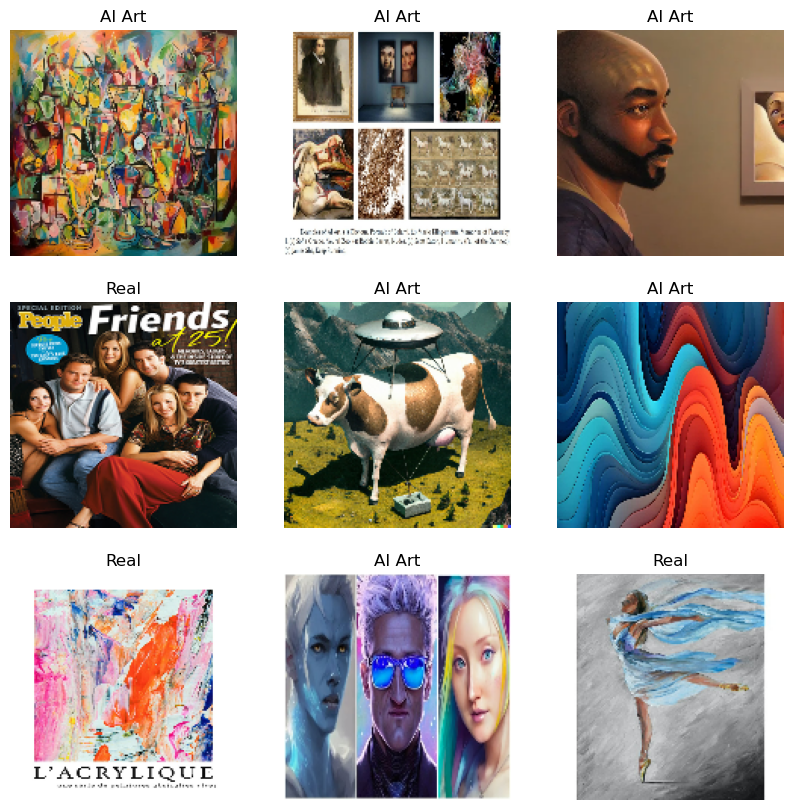

In [18]:
import matplotlib.pyplot as plt

def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")
display_binary_images(train_dataset, class_names)

In [19]:
rescale = keras.layers.Rescaling(1./255)

# Apply the rescaling to the datasets
train_dataset = train_dataset.map(lambda x, y: (rescale(x), y))
val_dataset = val_dataset.map(lambda x, y: (rescale(x), y))

## Importing InceptionV3


### Import InceptionV3 as our base model


In [20]:
base_model = keras.applications.InceptionV3(
    include_top=False, # Do not include the final layer, which classifies images
    weights="imagenet",
    input_shape=(HEIGHT, WIDTH, 3),
)

### Make base model layers non-trainable


In [21]:
for layer in base_model.layers:
    layer.trainable = False

## Fine-Tuning the model


### Add layers for Binary Image Classification


In [22]:
from keras import layers
# Starting layers

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

### Compile the Model


In [23]:
model = keras.Model(base_model.input, x)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics= ['accuracy']
)
# model.summary()

## Training the Model


### Util Methods


In [24]:
# Dynamic Learning Rate
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.1
    epochs_drop = 8
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) 
                                              / epochs_drop))
    return lr

In [25]:
EPOCHS = 50
stop = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, 
    monitor="val_loss", 
    start_from_epoch=5, 
    verbose=1)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(lr_schedule),
]

fine_tuned_model = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,  
)

Epoch 1/50


2024-05-16 00:10:47.137213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 310ms/step - accuracy: 0.5005 - loss: 51.3741 - val_accuracy: 0.5549 - val_loss: 3.3832 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.6134 - loss: 2.7163 - val_accuracy: 0.6978 - val_loss: 0.8149 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7043 - loss: 1.0333 - val_accuracy: 0.7527 - val_loss: 0.5415 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.7063 - loss: 0.6479 - val_accuracy: 0.6648 - val_loss: 0.6549 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.7221 - loss: 0.7399 - val_accuracy: 0.6264 - val_loss: 1.0669 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.8066 - loss: 0.5289 - val_accuracy: 0.6044 - val_loss: 1.5532 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.8415 - loss: 0.3896 - val_accu

## Evaluation of the Model


### Predicting a Specific Image


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
This image is Ai Art.


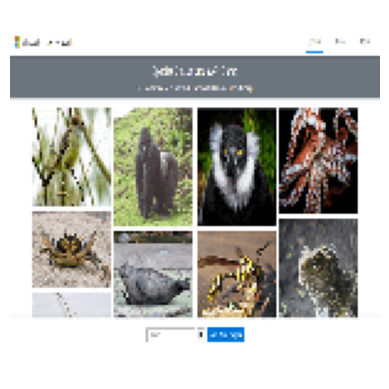

In [26]:
img_path = "dataset/AI Art vs Real Art/AI Art/AiArtData/0002_AI-in-animal-classification.png"

img = keras.preprocessing.image.load_img(img_path, 
                                            target_size=(HEIGHT, WIDTH))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]


# Scale predictions to percentages
total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

class_names = ["Ai Art", "Real"]  
pred = ", ".join(["%s" % class_names[i] for i, p in enumerate(scaled_predictions)])
print("This image is " + pred + ".")
plt.imshow(img)
plt.axis('off')
plt.show()

### Predicting a Random Image


dataset/AI Art vs Real Art/AI Art/AiArtData
canva-ai-best-image-generators-2023.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
This image is Ai Art.


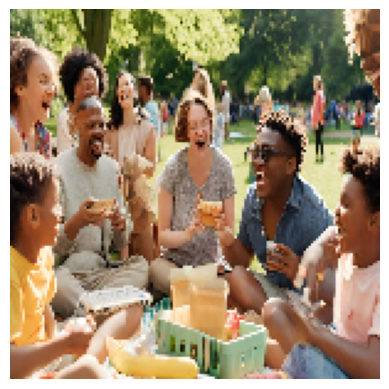

In [27]:
import os
import random
folder_number = random.randint(1, 2)  # Generate a random number between 1-3
if folder_number == 1:
    dataset_dir = "dataset/AI Art vs Real Art/AI Art/AiArtData"
else:
    dataset_dir = "dataset/AI Art vs Real Art/Real/RealArt"

print(dataset_dir)
file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)
print(random_file)
image_path = os.path.join(dataset_dir, random_file)

img = tf.keras.preprocessing.image.load_img(image_path, 
                                            target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]


# Scale predictions to percentages
total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

class_names = ["Ai Art", "Real"]  
pred = ", ".join(["%s" % class_names[i] for i, p in enumerate(scaled_predictions)])
print("This image is " + pred + ".")
plt.imshow(img)
plt.axis('off')
plt.show()

### Visualization in terms of Epochs


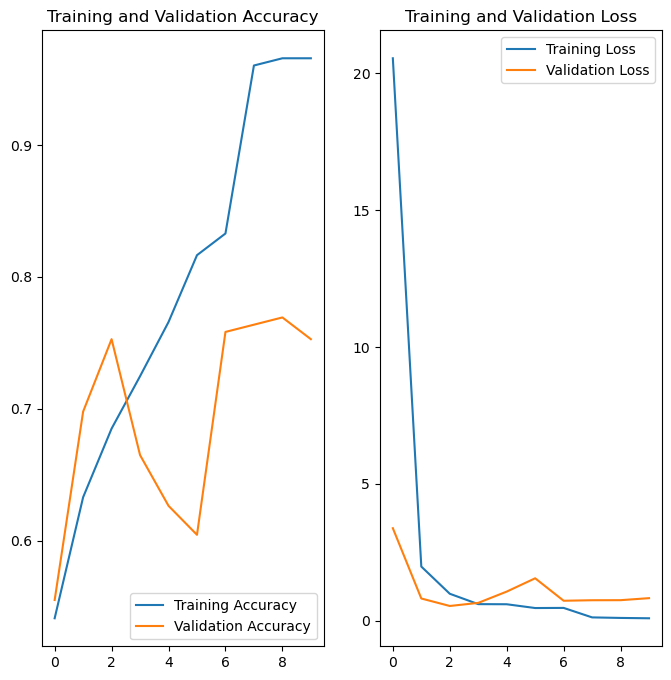

In [28]:
acc = fine_tuned_model.history['accuracy']
val_acc = fine_tuned_model.history['val_accuracy']

loss = fine_tuned_model.history['loss']
val_loss = fine_tuned_model.history['val_loss']
if stop.stopped_epoch != 0:
    epochs_range = range(stop.stopped_epoch+1)
else:
    epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()